In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
#! wget -o  ../../datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
column_names = 'label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'.split(', ')
data = pd.read_csv('../../datasets/HIGGS.csv.gz', header=None, names=column_names)

In [4]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, train_size=0.1, test_size=0.1, random_state = 5)

In [6]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [12]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [13]:
X_good.shape, X_bad.shape, X_train.shape, X_data.shape

((517088, 28), (582912, 28), (1100000, 28), (11000000, 28))

In [61]:
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import softmax
from lasagne.objectives import categorical_crossentropy

input_size = X_good.shape[1] # features cnt

input_var = T.matrix('input', dtype='float32')
weights_var = T.vector('weights', dtype='float32')
target_var = T.matrix('target', dtype='float32')
lr_var = T.scalar('learning rate')

network = InputLayer(shape=(None, input_size), input_var=input_var)
network = DenseLayer(network, 400)
network = DenseLayer(network, 2, nonlinearity=softmax)
output = lasagne.layers.get_output(network)

loss = (weights_var * categorical_crossentropy(output, target_var)).mean()
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.rmsprop(loss, params, learning_rate=lr_var)

train_fn = theano.function([input_var, weights_var, target_var, lr_var], [output, loss], updates=updates, allow_input_downcast=True)
predict_fn = theano.function([input_var], [output], allow_input_downcast=True)

In [62]:
X_min, X_max = np.min(X_data, axis=0), np.max(X_data, axis=0)

def random_sampling(size, features_range=[X_min, X_max]):
    return np.array([features_range[0][i] * np.ones(size) + np.random.rand(size) * (features_range[1][i] - features_range[0][i]) for i in range(len(features_range[0]))]).transpose()

In [63]:
import sys
sys.path.append('../../')
from hmc import *

In [ ]:
from sklearn.metrics import *
from keras.utils import to_categorical

lr = 1e-3
epoches = 1000
batch_size = 10000

true_bad_size = int(0.1 * y_train.sum())
fake_bad_size = int(0.9 * y_train.sum())
good_size = X_good.shape[0]

X_bad_true = X_train[y_train == 1][np.random.choice(np.arange(int(y_train.sum())), size=true_bad_size), :]
X_bad_fake = random_sampling(fake_bad_size)


target = np.concatenate([np.zeros(good_size), np.ones(true_bad_size + fake_bad_size)])
good_weights = np.ones(X_good.shape[0])
true_bad_weights = np.ones(true_bad_size)
fake_bad_weights = np.ones(fake_bad_size)

position = theano.shared(X_bad_fake)

def P(x):
    preds = x
    for layer in lasagne.layers.get_all_layers(network)[1:]:
        preds = layer.get_output_for(preds)
    preds = preds[:, 1]
    return 1 - T.exp(-preds / (1 - preds))

def get_P(x):
    preds = predict_fn(x)[0].squeeze()[:, 1]
    return 1 - np.exp(-preds / (1 - preds))

sampler = HMC_sampler.new_from_shared_positions(position, P,
                      initial_stepsize=1e-3, stepsize_max=0.5)

for epoch in range(epoches):
    if epoch % 30 == 0 and epoch > 0:
        lr /= 3
    print('Epoch: %d' % epoch)
    
    X_bad_fake = sampler.draw()
    
    X_mix = np.concatenate([X_good, X_bad_fake, X_bad_true])
    eps = 1e-4
    fake_bad_weights = 1./(eps + get_P(X_bad_fake))
    fake_bad_weights /= max(fake_bad_weights)
    
    weights = np.concatenate([good_weights, fake_bad_weights, true_bad_weights])
    indices = np.arange(len(weights))
    np.random.shuffle(indices)
    for i in range(int(len(indices)/batch_size)):
        batch_idx = indices[range(batch_size*i,min(batch_size*(i+1), len(indices)))]
        _, loss_value = train_fn(X_mix[batch_idx], weights[batch_idx], to_categorical(target[batch_idx]), lr)
    y_pred = predict_fn(X_test)[0].squeeze()[:, 1]
    print ("recall_score ",recall_score(y_test, np.round(y_pred)))
    # print ("accuracy score", accuracy_score(y_test_rescale, y_pred))
    print ("precision_score ",precision_score(y_test, np.round(y_pred)))
    print ("f1_score ",f1_score(y_test, np.round(y_pred)))
    print ("confusion_matrix ")
    print (confusion_matrix(y_test, np.round(y_pred)))
    acc_test = accuracy_score(y_test, np.round(y_pred))
    
    print('Loss: %.2f, Accuracy (test): %.2f' % (loss_value, acc_test))

Epoch: 0
('recall_score ', 0.006661382850241546)
('precision_score ', 0.9356626506024096)
('f1_score ', 0.013228585737111243)
confusion_matrix 
[[516821    267]
 [579029   3883]]
Loss: 0.16, Accuracy (test): 0.47
Epoch: 1
('recall_score ', 0.011711887900746596)
('precision_score ', 0.8573401984176818)
('f1_score ', 0.02310810239052253)
confusion_matrix 
[[515952   1136]
 [576085   6827]]
Loss: 0.16, Accuracy (test): 0.48
Epoch: 2
('recall_score ', 0.01812451965305226)
('precision_score ', 0.9357838795394154)
('f1_score ', 0.035560297676547704)
confusion_matrix 
[[516363    725]
 [572347  10565]]
Loss: 0.16, Accuracy (test): 0.48
Epoch: 3
('recall_score ', 0.015631862099253404)
('precision_score ', 0.9437597099948213)
('f1_score ', 0.03075432820254925)
confusion_matrix 
[[516545    543]
 [573800   9112]]
Loss: 0.16, Accuracy (test): 0.48
Epoch: 4
('recall_score ', 0.020694375823451912)
('precision_score ', 0.9315057915057915)
('f1_score ', 0.040489240797365836)
confusion_matrix 
[[51620

In [65]:
lr

1.8816764231589203e-09

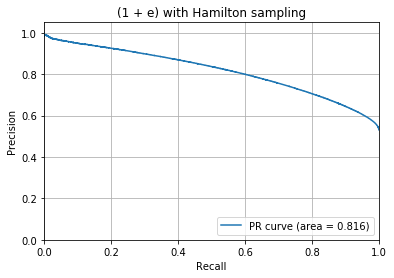

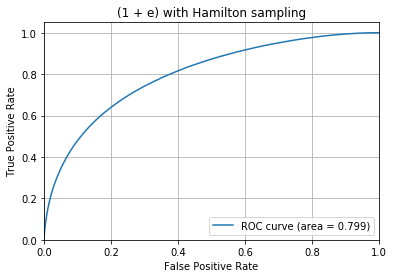

In [67]:
Score = y_pred

precision, recall, _ = precision_recall_curve(y_test, Score)
pr_auc = auc(recall, precision)

plt.figure()
plt.title('(1 + e) with Hamilton sampling')
plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

fpr, tpr, _ = roc_curve(y_test, Score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title('(1 + e) with Hamilton sampling')
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()